In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping




In [32]:
# Download Amazon (AMZN) data
data =pd.read_csv("HistoricalQuotes.csv")
data.head()


,Date,Close/Last,Volume,Open,High,Low
0,02/28/2020,$273.36,106721200,$257.26,$278.41,$256.37
1,02/27/2020,$273.52,80151380,$281.1,$286,$272.96
2,02/26/2020,$292.65,49678430,$286.53,$297.88,$286.5
3,02/25/2020,$288.08,57668360,$300.95,$302.53,$286.13
4,02/24/2020,$298.18,55548830,$297.26,$304.18,$289.23


Data Cleaning

In [33]:
data.columns = data.columns.str.strip()

In [34]:
dollar_col=["Close/Last","Open","High","Low"]
for col in dollar_col:
    data[col]=data[col].replace('[\$,]', '',regex=True).astype(float)

In [35]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [36]:
data.sort_values('Date',inplace=True)

In [37]:
data=data["Close/Last"]

**Data Splitting**

In [72]:
training_data_len = int(np.ceil(0.8 * len(data)))


train_data = data[:training_data_len].values.reshape(-1,1)
test_data = data[training_data_len - 60:].values.reshape(-1,1)



In [73]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data=scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)



Creating sequence

In [74]:
# Look-back window
look_back = 60


def create_sequences(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train_data, look_back)
# X_test, y_test = create_sequences(test_data, look_back)

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#test sequence

X_test = []
y_test_actual=data[training_data_len:]

for i in range(look_back, len(scaled_test_data)): # Use scaled test data
    X_test.append(scaled_test_data[i - look_back:i, 0])

X_test = np.array(X_test)

# 8. Reshape for LSTM (Test Data)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


Building the model

In [59]:
# Build model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')
#training

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True) # Early stopping

history = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping], verbose=1) # Increased epochs




Epoch 1/100


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0266
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0018
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0013
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0011
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0012
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0012
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 9.4254e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 9.2242e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 9.3357e-04
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 8.5081e-04
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 7.9529e-04
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 7.8517e-04
Epoch 13/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 9.4774e-04
Epoch 14/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.0827e-04
Epoch 15/100
62/62 ━━━━━━━━━━━━━━━━

tRaining the model

Prediction


In [15]:
# X_test, y_test = [], data[training_data_len:]  # real prices (unscaled)

# for i in range(look_back, len(test_data)):
#     X_test.append(test_data[i-look_back:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [75]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [76]:

from sklearn.metrics import mean_squared_error,mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f'Root Mean Squared Error: {rmse}')
print("MAE:", mean_absolute_error(y_test_actual, predictions))

Root Mean Squared Error: 4.964649311624826
MAE: 3.495269112861891


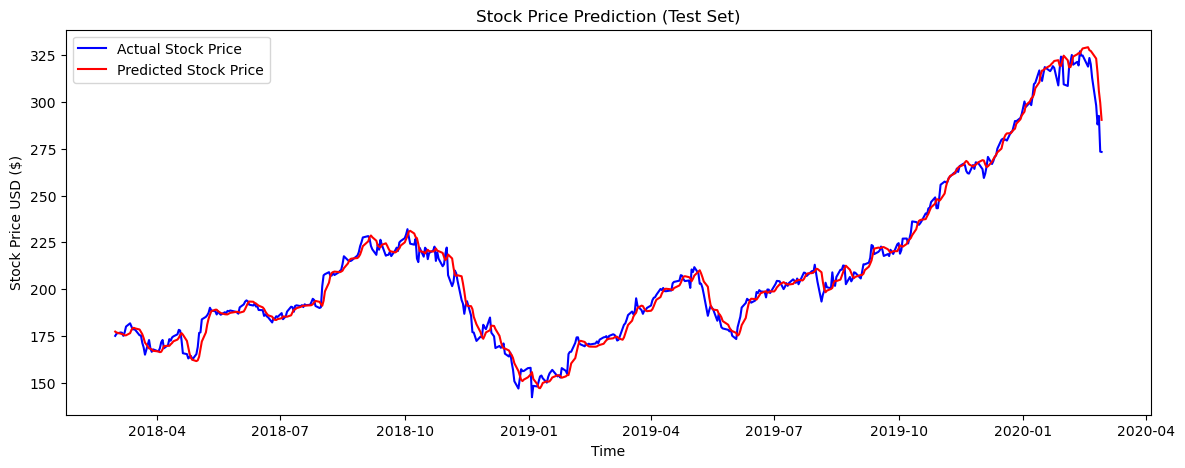

In [78]:
plt.figure(figsize=(14,5))
plt.plot(y_test_actual.index,y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(y_test_actual.index,predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (Test Set)')
plt.xlabel('Time')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()


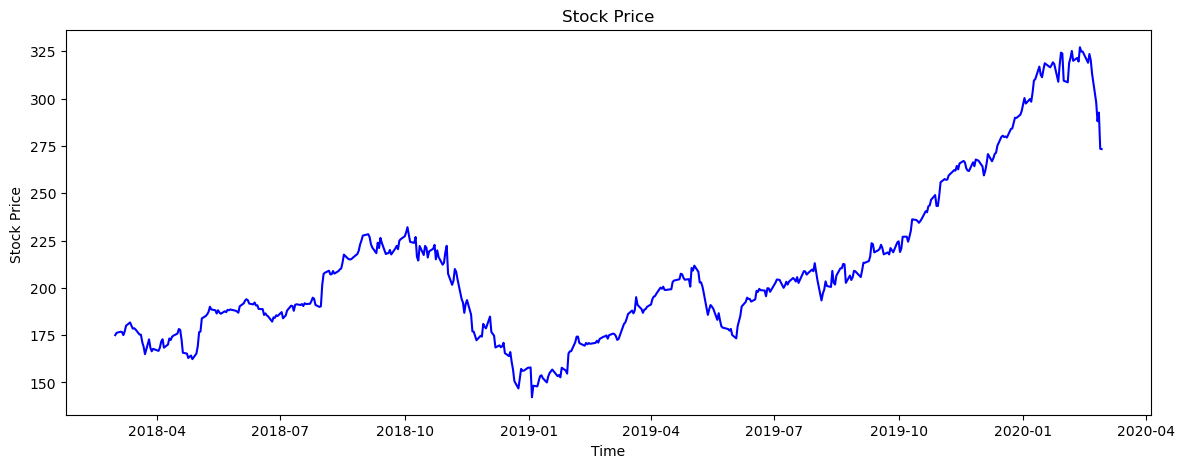

In [80]:
plt.figure(figsize=(14,5))
plt.plot(y_test_actual.index,y_test_actual, color='blue', label='Actual Stock Price')
#plt.plot(y_test_actual.index,predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price ')
plt.show()